<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Description
This project uses the [consumer complaint database](https://catalog.data.gov/dataset/consumer-complaint-database).

## Data Description
The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.

## Purpose
Classify consumer complaints into predefined categories.

Classification algorithms
- Linear Support Vector Machine (LinearSVM)
- Multinomial Naive Bayes 
- Logistic Regression.

# Imports

In [1]:
import time
time_start_notebook = time.time()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tqdm

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') 

# random state
SEED=100

[(x.__name__,x.__version__) for x in [np,pd,sns,sklearn,tqdm]]

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[('numpy', '1.18.4'),
 ('pandas', '1.0.3'),
 ('seaborn', '0.9.0'),
 ('sklearn', '0.23.0'),
 ('tqdm', '4.46.0')]

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [7]:
import joblib

In [8]:
#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load the data

In [9]:
!ls ../data

complaints.csv       complaints.csv.zip   complaints.json.zip  data_clean.csv       id_to_product.csv    small_complaints.csv


In [10]:
df = pd.read_csv('../data/data_clean.csv')
df.head(2).append(df.tail(2)).T

,0,1,645,646
product,Mortgage,"Credit reporting, credit repair services, or o...",Debt collection,Credit card or prepaid card
complaint,Hello : ditech.com is my mortgage company. The...,This a formal complaint against TransUnion reg...,The company is reporting to the credit bureau ...,I returned merchandise to a merchant in the am...
category_id,0,1,6,3
complaint_lst,"['helo', 'ditechcom', 'mortgage', 'company', '...","['formal', 'complaint', 'trans', 'union', 'reg...","['company', 'reporting', 'credit', 'bureau', '...","['returned', 'merchandise', 'merchant', 'amoun..."
complaint_clean,helo ditechcom mortgage company placed automat...,formal complaint trans union regarding inacura...,company reporting credit bureau debt owe ever ...,returned merchandise merchant amount merchant ...


In [11]:
df_id_to_product = pd.read_csv('../data/id_to_product.csv')
ser_id_to_product = df_id_to_product.iloc[:,0]
ser_id_to_product

0                                              Mortgage
1     Credit reporting, credit repair services, or o...
2             Payday loan, title loan, or personal loan
3                           Credit card or prepaid card
4                           Checking or savings account
5                                 Vehicle loan or lease
6                                       Debt collection
7     Money transfer, virtual currency, or money ser...
8                                          Student loan
9                               Bank account or service
10                                        Consumer Loan
Name: 0, dtype: object

# Get vectorized data from text

In [12]:
%%time 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# create vectors
features = tfidf.fit_transform(df['complaint_clean']).toarray()
labels = df['category_id']

CPU times: user 157 ms, sys: 13 ms, total: 170 ms
Wall time: 202 ms


# Train Test Split

In [13]:
%%time

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test,indices_train,indices_test = \
    train_test_split(features, labels, df.index,
                     test_size=0.25, random_state=SEED,stratify=labels)

y_train[:2]

CPU times: user 4.63 ms, sys: 2.94 ms, total: 7.58 ms
Wall time: 7.6 ms


544    1
41     3
Name: category_id, dtype: int64

In [14]:
sorted(y_train.unique()), sorted(y_test.unique())

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Fit various Models

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [16]:
# ?RandomForestClassifier

In [17]:
models = [
    LogisticRegression(random_state=SEED),
    LinearSVC(),
    MultinomialNB(),
    
]

model_names = ['LogisticRegression', 'SVC', 'MultinomialNB']
dic_models = dict(zip(model_names,models))

for model_name, model in dic_models.items():
    print(model_name)

LogisticRegression
SVC
MultinomialNB


In [18]:
%%time

from sklearn.model_selection import cross_val_score

accs = []

for model in models:
    acc = cross_val_score(model, X_train, y_train,scoring='accuracy').mean()
    accs.append(acc)
    
df_models = pd.DataFrame({'Model': model_names, 'Accuracy': accs})
df_models

CPU times: user 2.77 s, sys: 235 ms, total: 3.01 s
Wall time: 1.15 s


,Model,Accuracy
0,LogisticRegression,0.558763
1,SVC,0.668041
2,MultinomialNB,0.430928


# Model Evaluation

In [21]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
# Classification report
print(metrics.classification_report(y_test, y_pred, 
    target_names= df['product'].unique()))

                                                                              precision    recall  f1-score   support

                                                                    Mortgage       0.87      0.81      0.84        16
Credit reporting, credit repair services, or other personal consumer reports       0.76      0.87      0.81        63
                                   Payday loan, title loan, or personal loan       0.00      0.00      0.00         2
                                                 Credit card or prepaid card       0.52      0.61      0.56        18
                                                 Checking or savings account       0.67      0.33      0.44         6
                                                       Vehicle loan or lease       0.00      0.00      0.00         3
                                                             Debt collection       0.69      0.83      0.75        35
                          Money transfer, virtual curre

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


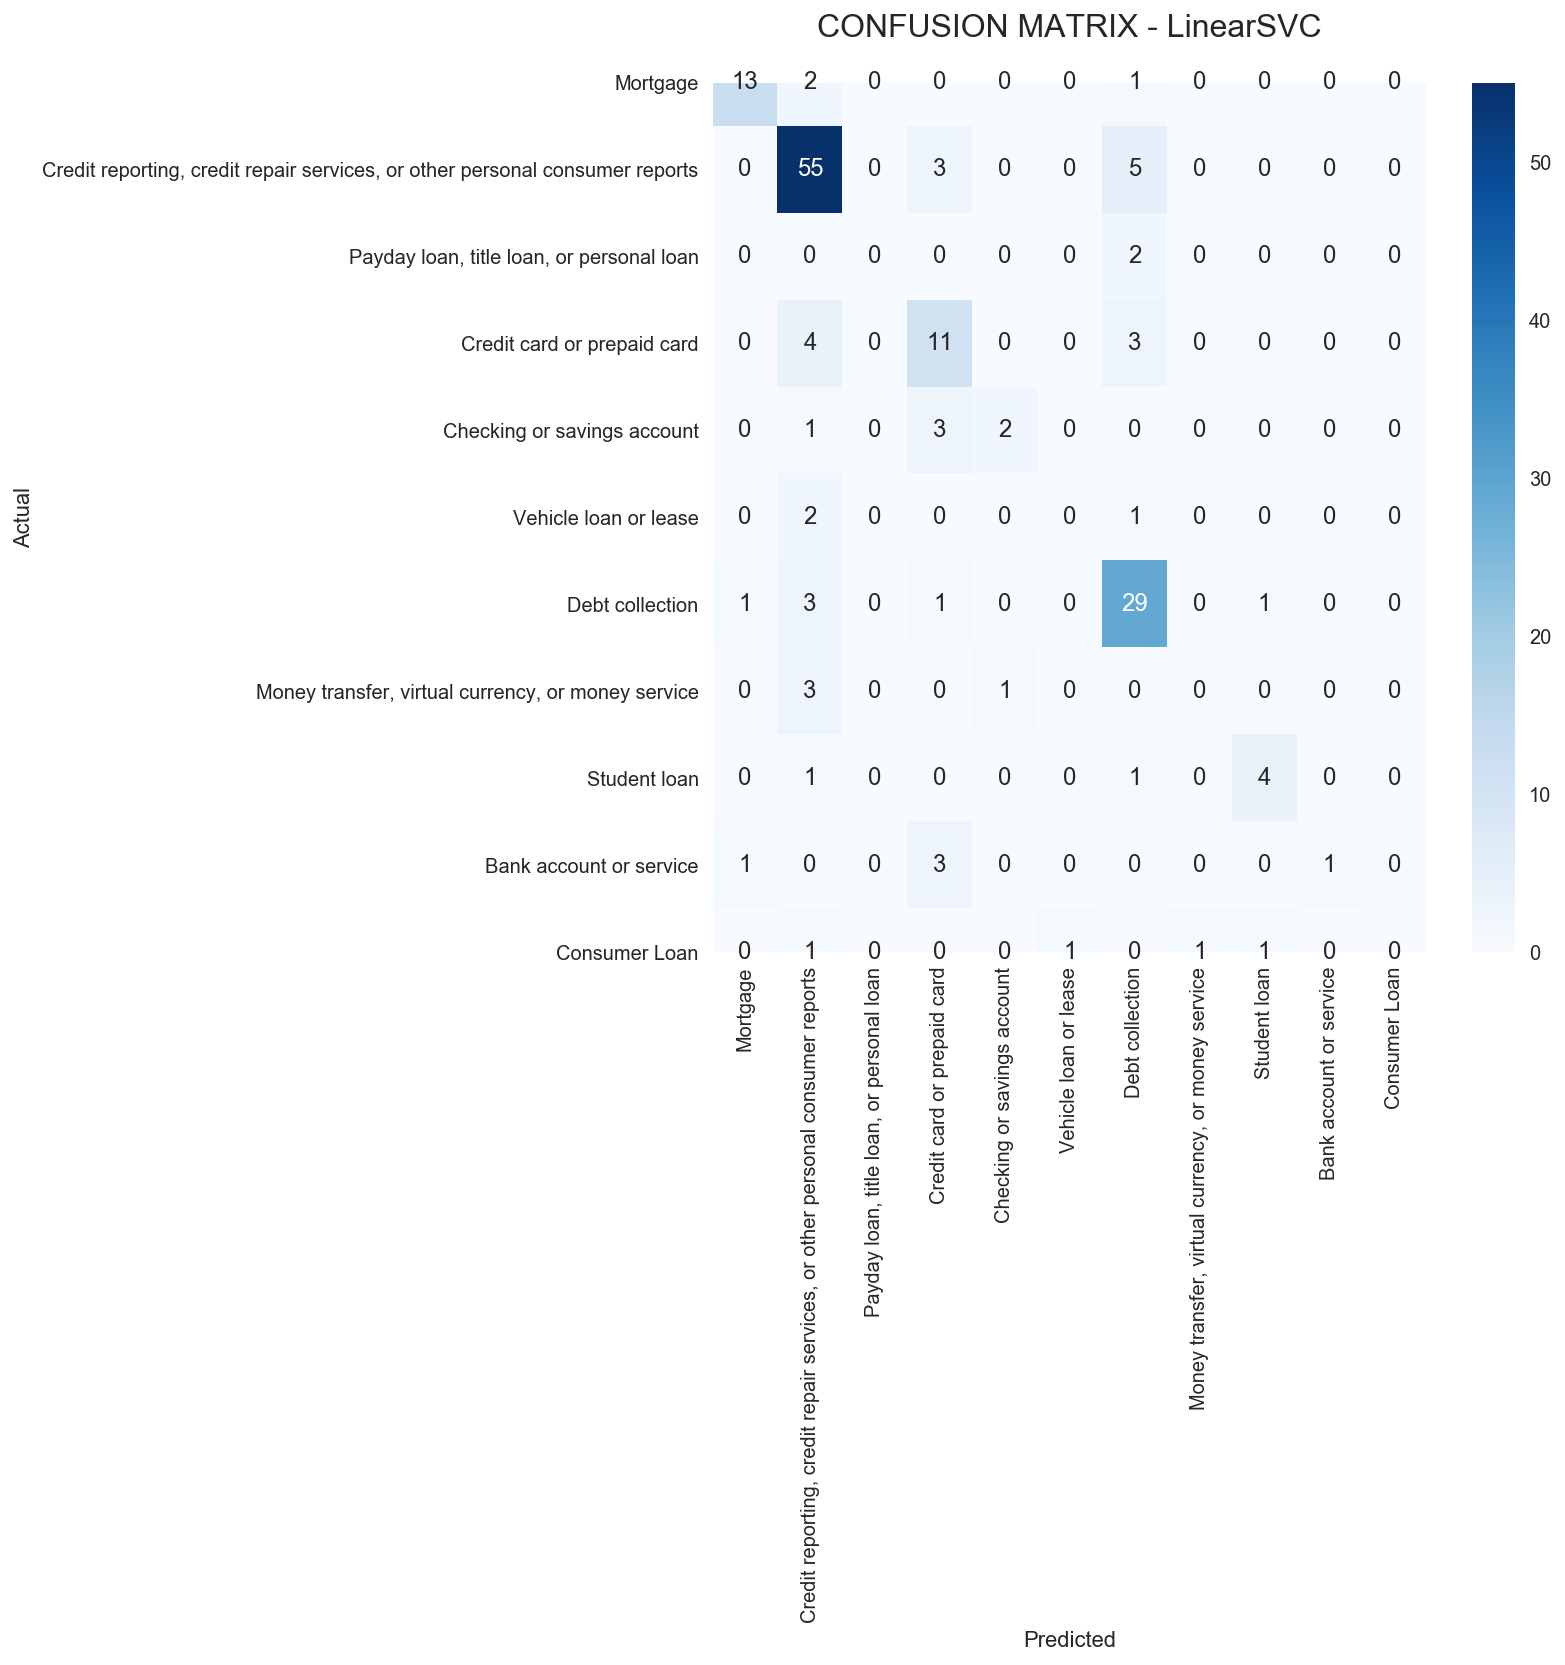

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=ser_id_to_product.values, 
            yticklabels=ser_id_to_product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [24]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

# select classifiers 
classifiers=[
LogisticRegression(random_state=SEED),
LinearSVC()
]

model = LinearSVC()
classes = ser_id_to_product.values

In [25]:
# ?ClassificationReport

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


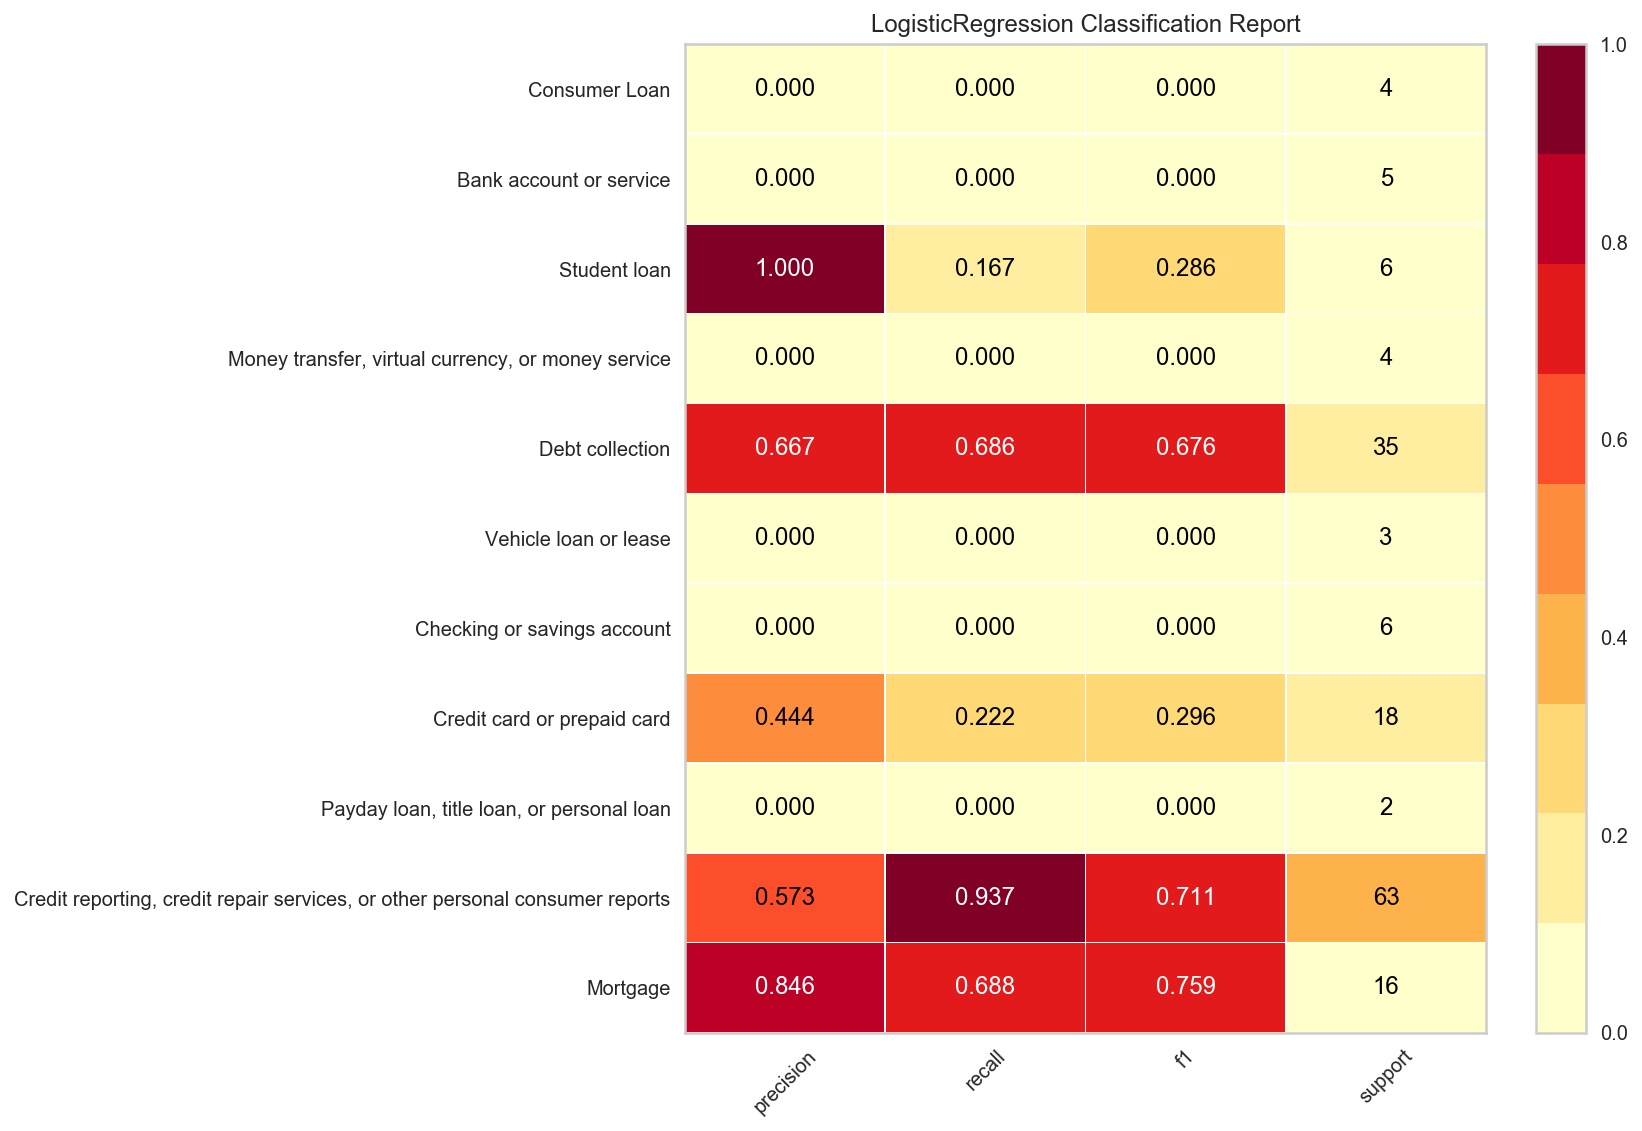

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


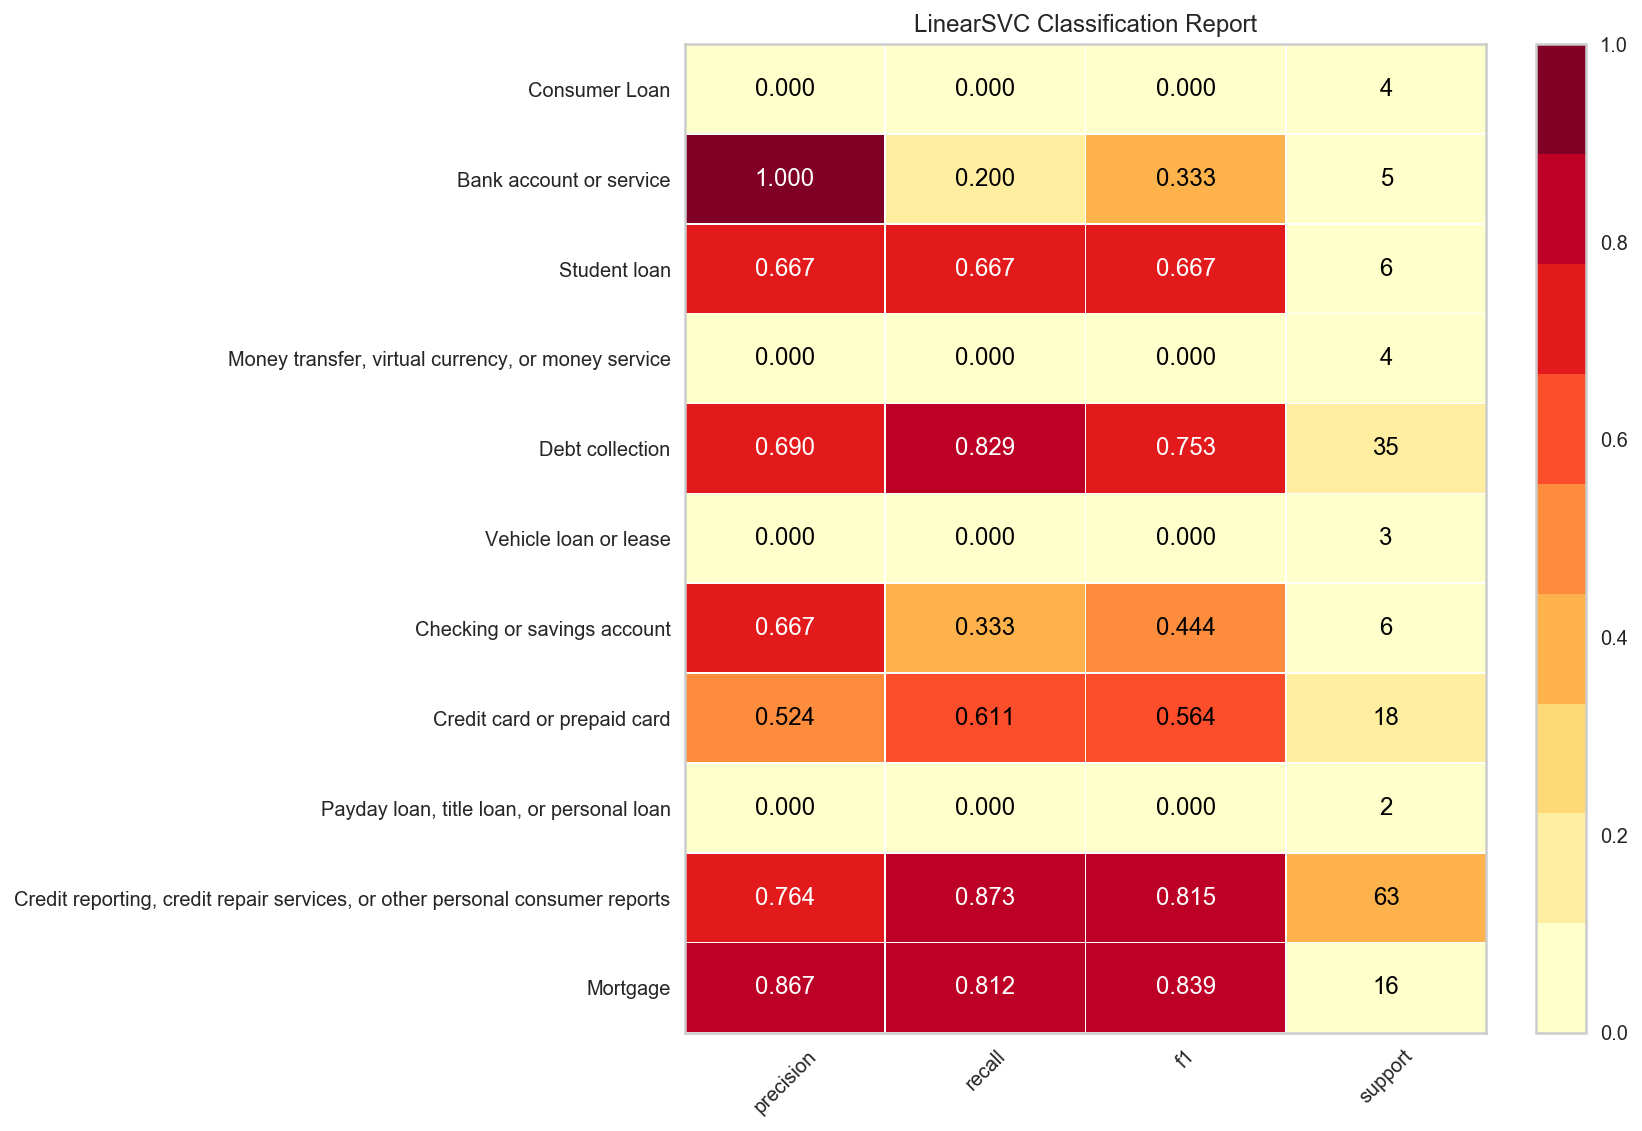

In [26]:
def viz_metrics(visualizer):
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()

for clf in classifiers:
    plt.close()
    fig,ax = plt.subplots(figsize=(12,8))
    visualizer = ClassificationReport(clf, classes=classes, support=True)
    viz_metrics(visualizer)

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


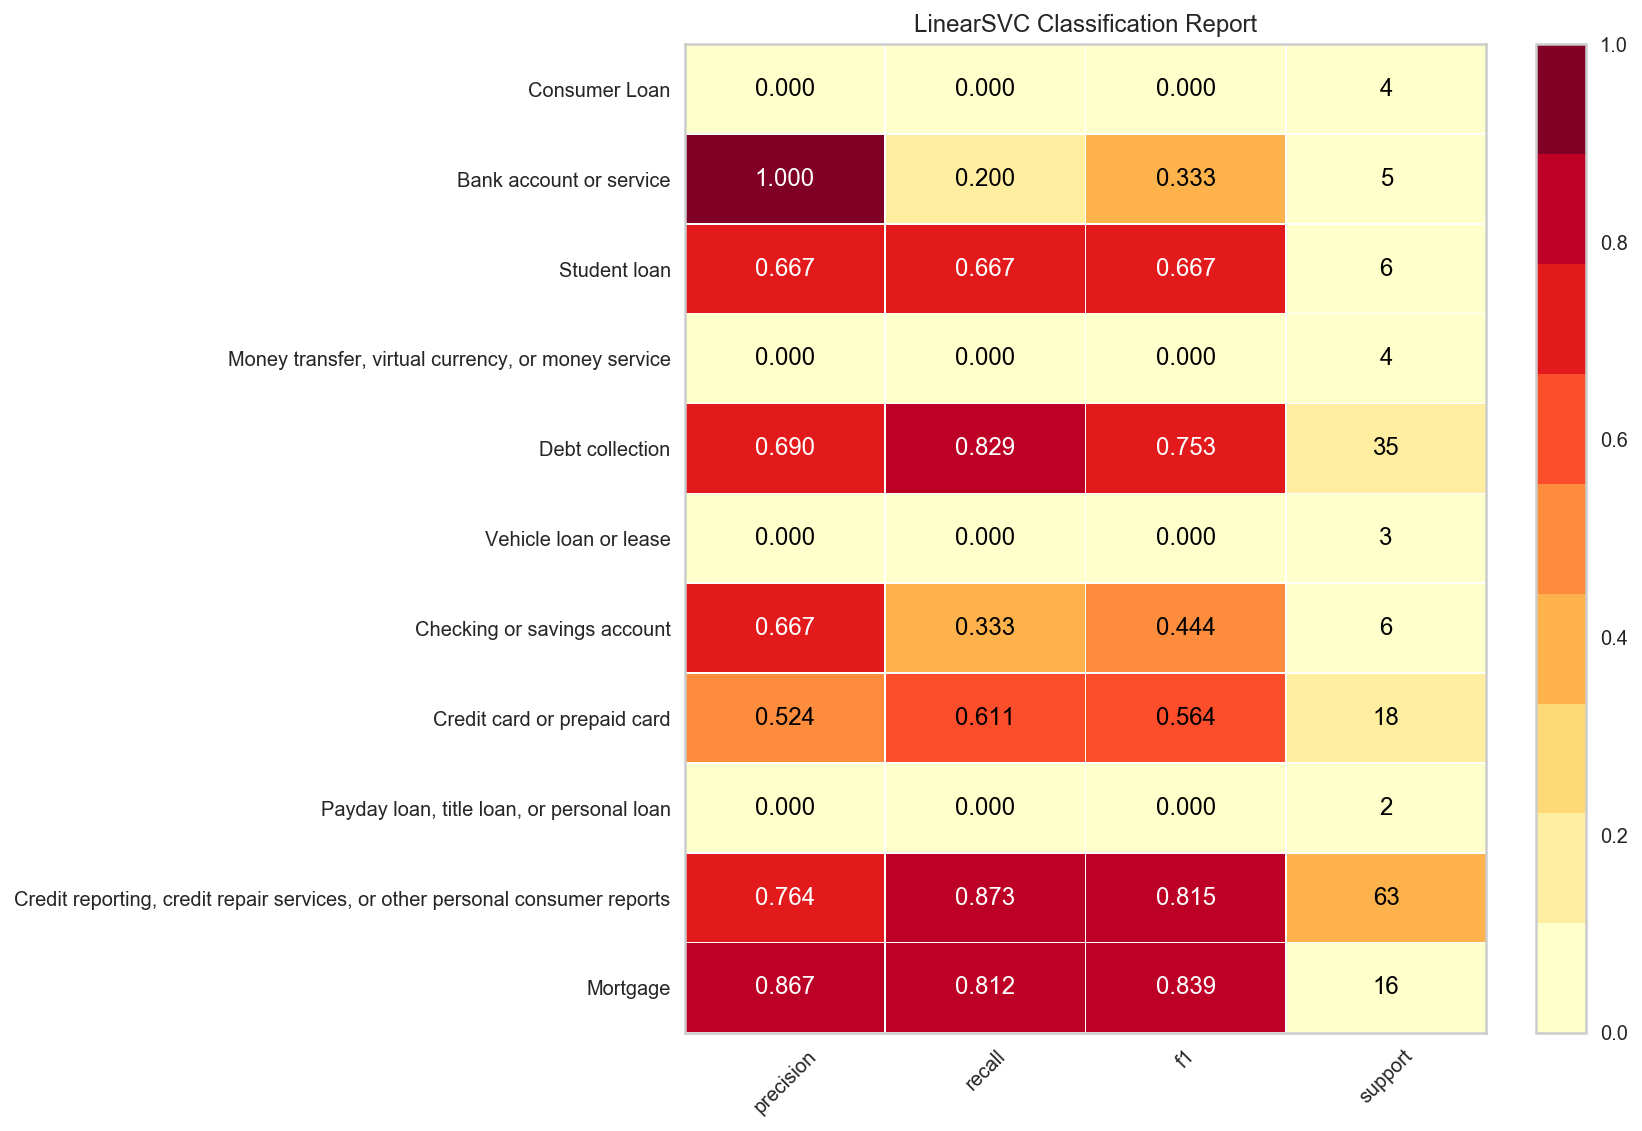

In [27]:
fig,ax = plt.subplots(figsize=(12,8))
visualizer = ClassificationReport(model, classes=classes, support=True)
viz_metrics(visualizer)

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


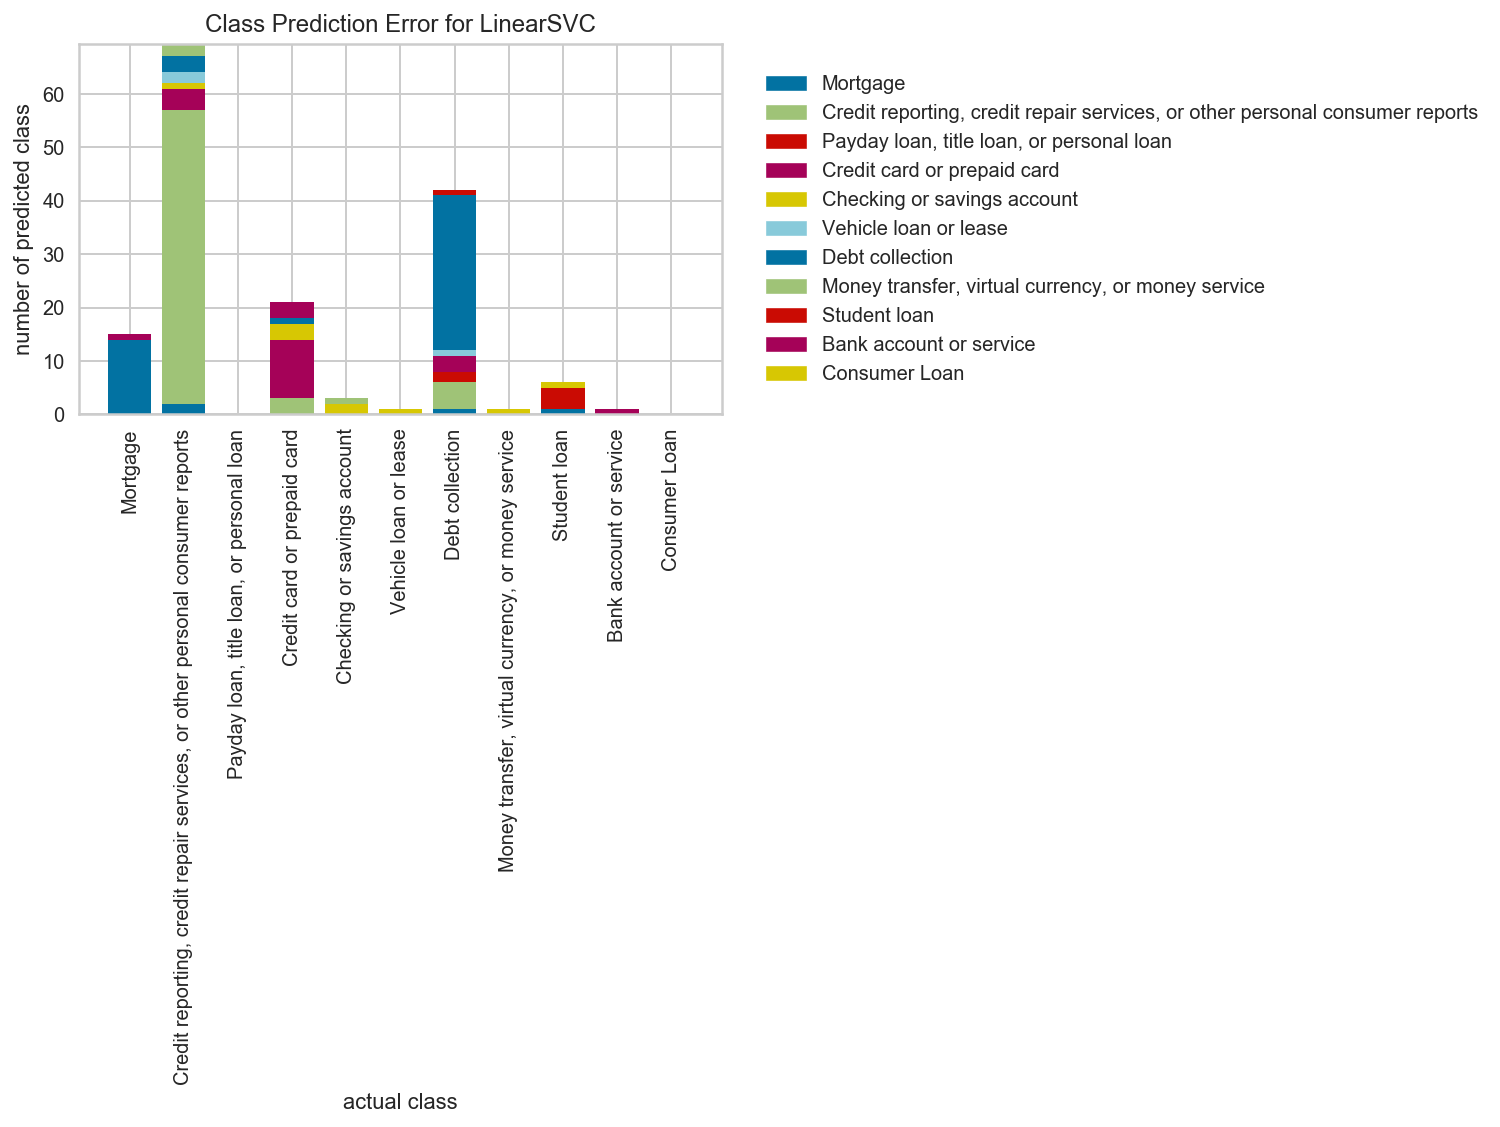

In [28]:
fig,ax = plt.subplots(figsize=(12,8))
visualizer = ClassPredictionError(LinearSVC(), classes=classes)
viz_metrics(visualizer)

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


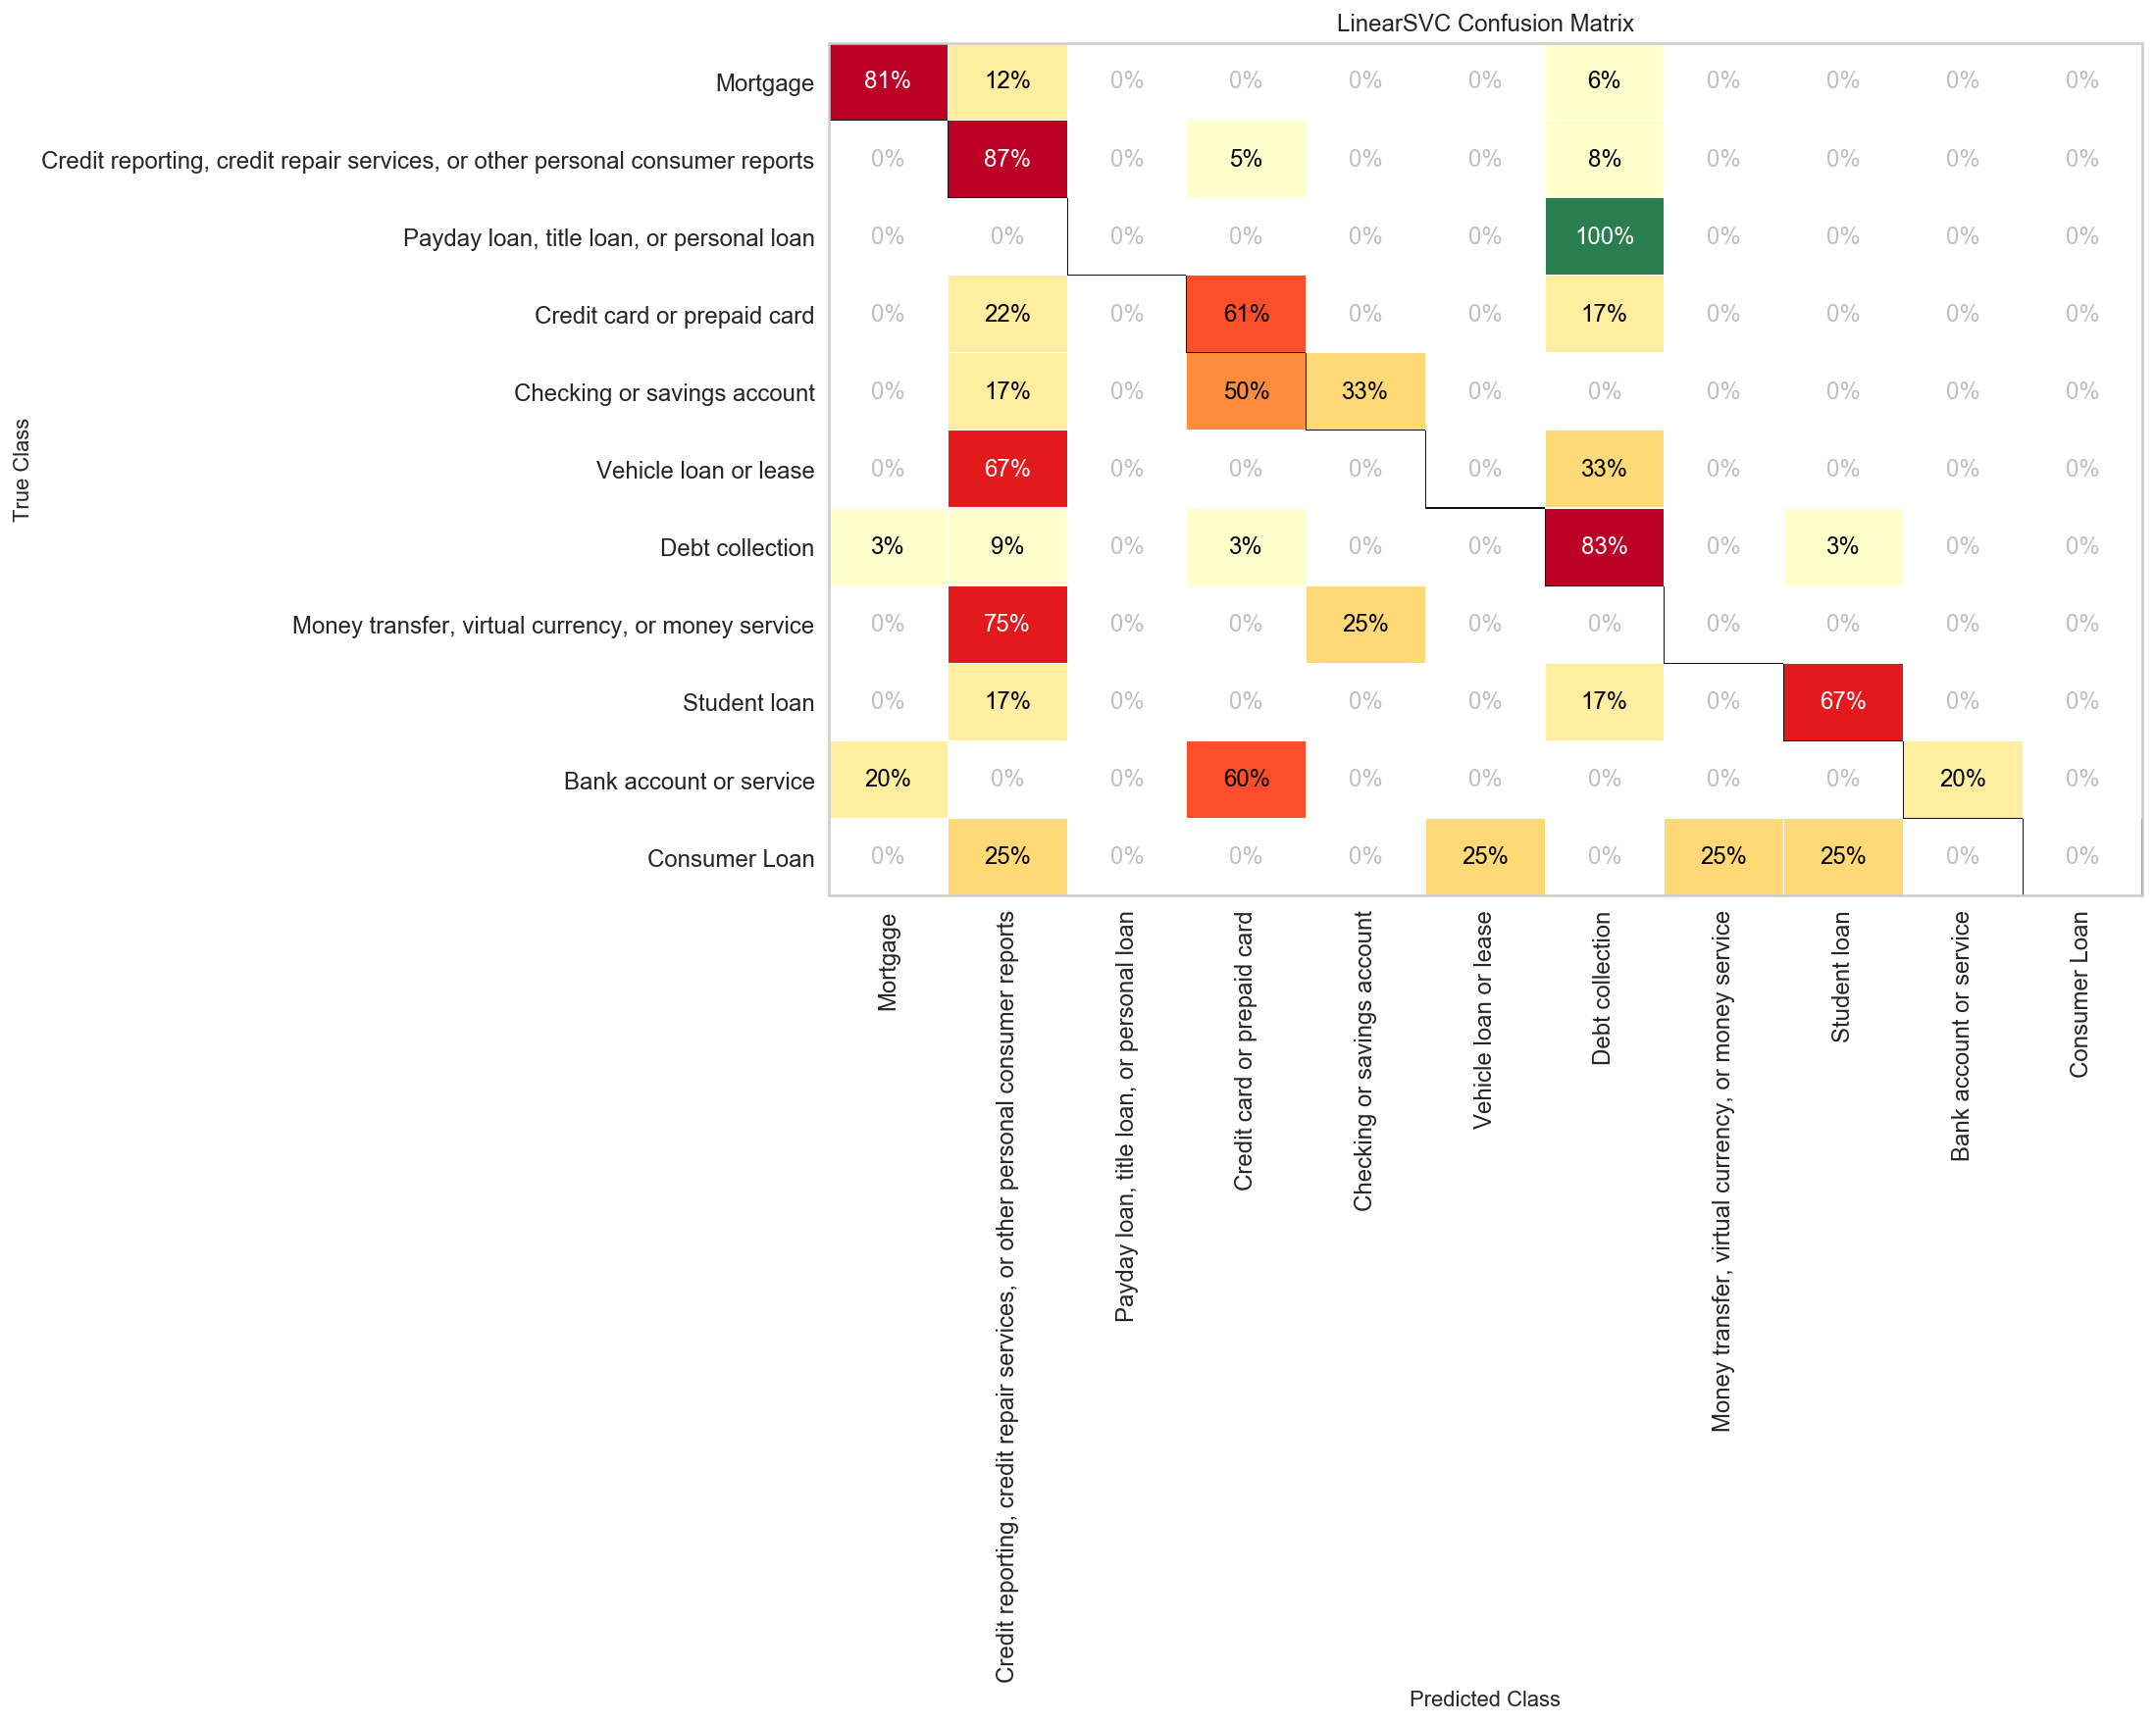

In [29]:
fig,ax = plt.subplots(figsize=(12,8))
visualizer = ConfusionMatrix(model, classes=classes,percent=True)
viz_metrics(visualizer)

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


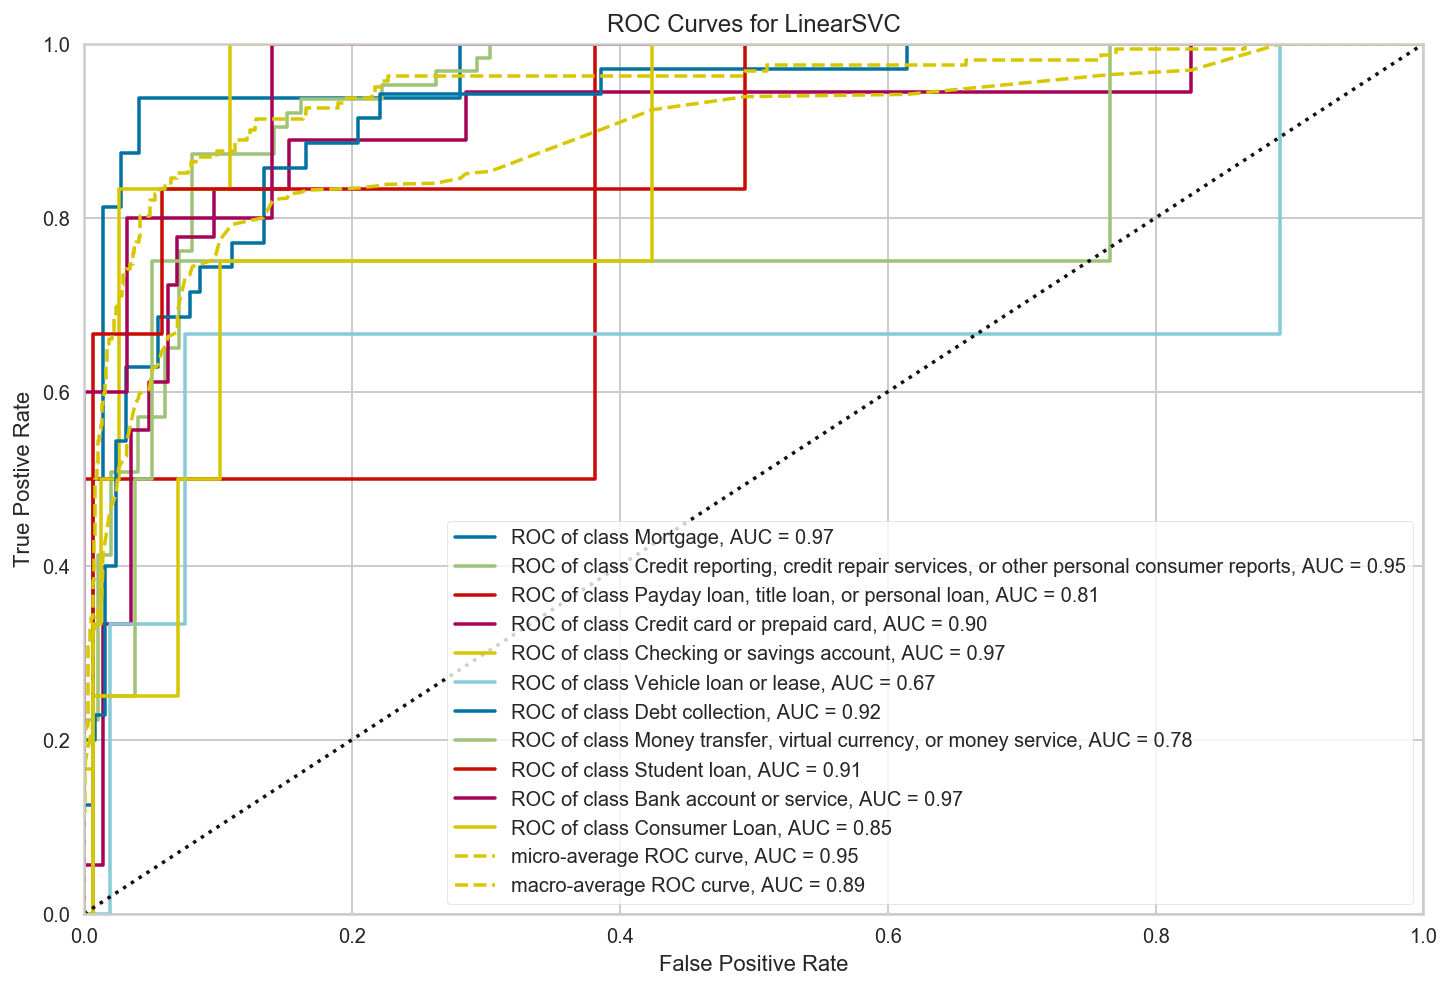

In [30]:
# ROC-AUC
fig,ax = plt.subplots(figsize=(12,8))
visualizer = ROCAUC(model, classes=classes)
viz_metrics(visualizer)

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


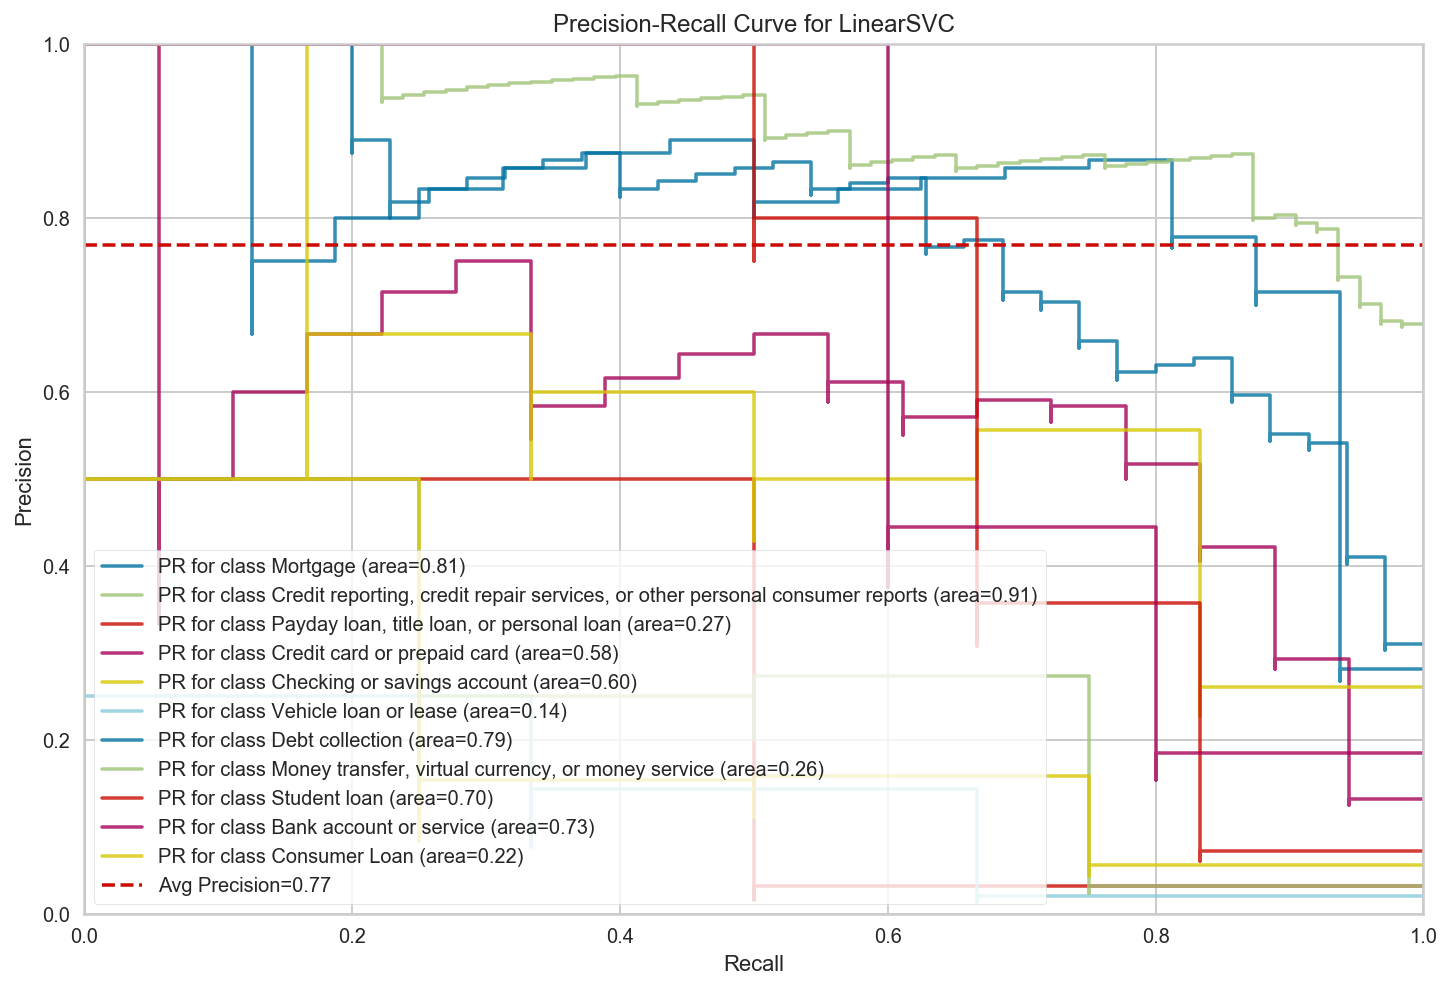

In [31]:
# Precision Recall Curve
fig,ax = plt.subplots(figsize=(12,8))
visualizer = PrecisionRecallCurve(model,classes=classes,per_class=True,
                                  iso_f1_curves=False,fill_area=False, micro=False)
viz_metrics(visualizer)

# Mis-classified Cases

In [32]:
ser_id_to_product

0                                              Mortgage
1     Credit reporting, credit repair services, or o...
2             Payday loan, title loan, or personal loan
3                           Credit card or prepaid card
4                           Checking or savings account
5                                 Vehicle loan or lease
6                                       Debt collection
7     Money transfer, virtual currency, or money ser...
8                                          Student loan
9                               Bank account or service
10                                        Consumer Loan
Name: 0, dtype: object

In [33]:
for predicted in ser_id_to_product.index:
    for actual in ser_id_to_product.index:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_product[actual], 
                                                               id_to_product[predicted], 
                                                               conf_mat[actual, predicted]))
            # indices_test is from train-test split
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['product', 
                                                                    'complaint']])
            print('')

# Most correlated terms with each category

In [34]:
model.fit(features, labels)

products = []
top3uni = []
top3bi = []

N = 4
for category_id, product in ser_id_to_product.iteritems():
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    products.append(product)
    top3uni.append(', '.join(unigrams[-N:]))
    top3bi.append(', '.join(bigrams[-N:]))

In [35]:
df_top_corr = pd.DataFrame({'product': products, 'unigram': top3uni, 'bigram': top3bi})
df_top_corr

,product,unigram,bigram
0,Mortgage,"mortgage, modification, refinance, home","mortgage company, mortgage payment, bank ameri..."
1,"Credit reporting, credit repair services, or o...","equifax, experian, credit, acounts","reporting agency, late xx, credit reporting, x..."
2,"Payday loan, title loan, or personal loan","loan, income, online, los","report report, xx time, make payment, xx pa"
3,Credit card or prepaid card,"card, statement, capital, purchase","american expres, customer service, incorect in..."
4,Checking or savings account,"debit, checking, bonus, lost","debit card, checking acount, closed acount, fr..."
5,Vehicle loan or lease,"lender, vehicle, payment, want","contract xx, auto loan, xxxx xxxx, statute lim..."
6,Debt collection,"debt, colection, cal, contact","dispute xx, acount number, debt colector, ben xx"
7,"Money transfer, virtual currency, or money ser...","fund, transfer, money, reply","xx bank, check xx, acount day, state xx"
8,Student loan,"navient, loan, deferment, student","student loan, pay loan, payment plan, xxxx xxxx"
9,Bank account or service,"bank, estate, wel, deposited","fund acount, acount acount, close acount, agen..."


# Predictions

In [36]:
X = df['complaint_clean'] # documents
y = df['product'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = SEED)

In [37]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [38]:
# Save the fitted model (model persistence)
joblib.dump(model, '../models/tfidf.pkl')

['../models/tfidf.pkl']

In [39]:
new_complaint = """Hello : ditech.com is my mortgagecompany.
They placed an automatic forbearance on my account
and removed my auto payment after
Hurricane Irma. 
I called about a week after the storm
to ask that they remove the forbearance
and return the auto payment.
This was confirm by the agent
and recorded by them. 
I received a letter just a few 
weeks ago stating that my auto payment
was never returned and the agent who
I spoke with after I received the
letter actually read back the notes
confirming that I called and asked 
to have forbearance removed and auto
payment reinstated.
So I asked again the agent 
to remove the forbearance and install auto payment.
\n\nI called this past week to check 
if this was done yet, and the agent
at that time said I still have 
a forbearance and no auto payment.
\n\nAs I right this complaint,
I spoke with an agent today that
informs me that I dont have auto 
payment and forbearance is still active.
She placed me on hold, which has lasted an hour.
\n\nDitech is not responsive,
and it is purposely choosing 
to keep my in forbearance when
I have asked countless times to remove me.
I also have asked countless times 
to reinstate auto payment and yet 
they choose not to listen.
\n\nPlease help XXXX XXXX, XXXX"""

In [40]:
model_loaded = joblib.load('../models/tfidf.pkl')
new_comp_vec = fitted_vectorizer.transform([new_complaint])
pred = model_loaded.predict(new_comp_vec)

print(pred)

['Mortgage']


# Total Time Taken

In [41]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 4 min 31 secs
